In [1]:
#w_ji connections
#i is the current neuron
#j is the other neuron

In [2]:
import random
import math
from tqdm import tqdm_notebook
import itertools
from GeneticAlgorithm import *
from ctrnn import *
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#plt.style.use("dark_background")

In [3]:
def getRandomWeight():
    return random.uniform(-15, 15)

def getRandomBias():
    return random.uniform(-15, 15)

def getRandomTau():
    return random.uniform(0.1, 1)

def getRandomState():
    return random.uniform(-5, 5)

#make the individual
class NetworkIndividual(AbstractLinkedListIndividual):
    def __init__(self, neuron_count = 5):
        self.genotype = []
        self.encode_network(neuron_count)
        
    def encode_network(self, neuron_count):
        self.neuron_count = neuron_count
        
        #bias
        bias_ls = [getRandomBias() for i in range(self.neuron_count)]
        #tau
        tau_ls = [getRandomTau() for i in range(self.neuron_count)]
        #states
        state_ls = [getRandomState() for i in range(self.neuron_count)]
        #weights
        weight_ls = [getRandomWeight() for i in range(self.neuron_count * self.neuron_count)]
            
        #genotypeItertool = itertools.chain([self.neuron_count], bias_ls, tau_ls, state_ls, weight_ls)
        #self.genotype = list(genotypeItertool)
        self.genotype = [self.neuron_count]
        self.genotype.extend(bias_ls)
        self.genotype.extend(tau_ls)
        self.genotype.extend(state_ls)
        self.genotype.extend(weight_ls)
        
    def mutate(self, mutation_rate):
        
        bias_offset = 1
        tau_offset = bias_offset + self.neuron_count
        state_offset = tau_offset + self.neuron_count
        weight_offset = state_offset + self.neuron_count
        
        #Skip over the neuron_count in genome
        #TODO: Change this to use the new mutation that is less like random search
        for i in range(bias_offset, len(self.genotype)):
            if random.random() < mutation_rate:
                if i >= weight_offset:
                    self.genotype[i] = getRandomWeight()
                elif i >= state_offset:
                    self.genotype[i] = getRandomState()
                elif i >= tau_offset:
                    self.genotype[i] = getRandomTau()
                elif i >= bias_offset:
                    self.genotype[i] = getRandomBias()

In [4]:
#make the individual
class OscillatingNetworkIndividual(NetworkIndividual):
    def __init__(self, neuron_count = 3):
        self.genotype = []
        self.encode_network(neuron_count)
    
    def fitness(self):
        n = FullyConnectedCTRNN.create_network(self.genotype)
        
        abs_slope_totals = [0.0 for i in range(len(n.neurons))]
        last_output = []
        
        step_size = 0.1
        step_count = 15
        outputs = [n.euler_step(None, step_size) for i in range(step_count)]
        
        for i in range(1, len(outputs)):
            #Sum of total changes in slopes
            for j in range(len(n.neurons)):
                slope = outputs[i-1][j] - outputs[i][j]
                abs_slope_totals[j] += abs(slope)
        
        #Use slope totals to determine if neuron should be oscillating
        output = 0.0
        #A neuron that has a total slope of 500% of the x distance traversed is considered oscillating, partial credit is received
        for abs_slope_total in abs_slope_totals:
            output += min(abs_slope_total / (2 * step_count * step_size), 1.0) #Max is 1.0
            #print("fitness a:", fitness)
        output /= len(n.neurons) #Make each neuron only worth part of the fitness
        #print("fitness b:", fitness)
        return output #normalizze fitness out of [0, 1.0]

In [5]:
#A helping funciton for graphing highest performing individual of a population
def graph_highest_fitness(pop, gen_count):
    test_network = FullyConnectedCTRNN.create_network(pop.fittest_individual.genotype)
    print("weights: [")
    for neuron in test_network.neurons:
        print("\t", neuron.weights)
    print("]")
    print("taus:", [neuron.tau for neuron in test_network.neurons])
    print("bias:", [neuron.bias for neuron in test_network.neurons])
    
    x = []
    y = []
    
    time_step = 0.1
    step_count = 15
    for i in range(step_count):
        x.append(time_step * i)
        y.append(test_network.euler_step(None, time_step))

    #Plot output of each neuron
    plt.title("Output of neurons")
    plt.plot(x, y, '-')
    plt.ylim(0.0, 1.1)
    plt.ylabel("output")
    plt.xlabel("time step")
    plt.show()
    
    #Highest performing over time plot
    #plt.title("Best performing per generation")
    #for point in pop.best_performing_per_generation:
    plt.title("Best performing per generation")
    plt.plot(*zip(*pop.best_performing_per_generation), '.', markersize=12)
    plt.xlim(0, gen_count)
    plt.ylim(0, 1.1)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.show()
    
    print("\n\n\n\n\n")

In [6]:
# %%prun -s cumulative -q -l 10 -T prun4

#Generates 20 seperate populations, and runs reproduction 3000 times on each
population_size = 100
gen_count = 3000

population_count = 20
populations = [TournamentPopulation(OscillatingNetworkIndividual, population_size) for i in range(population_count)]
for i in tqdm_notebook(range(len(populations))):
    pop = populations[i]
    for gen in range(gen_count):
        pop.run_cycle(gen=gen)

Top 5 performing
weights: [
	 [-4.157593219277852, 0.2993553009926213, 4.968887301730078]
	 [11.087002073101967, -8.758364566742767, -4.583641691222219]
	 [10.562211086146217, 11.881160308037735, -13.524137776141279]
]
taus: [0.16987688546587398, 0.11419938699748805, 0.1288813477337211]
bias: [1.460081998399076, -3.4204240677689395, -4.940534872856444]


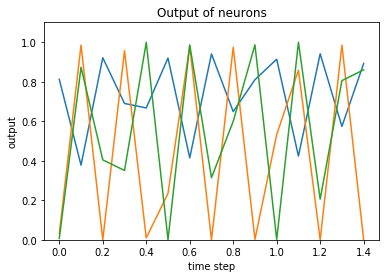

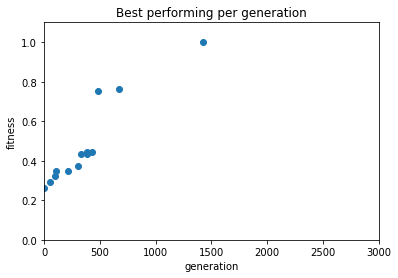







weights: [
	 [4.411061621640702, -0.6210800589527246, -4.451750451531659]
	 [1.1204611471163872, -9.4714987503399, 0.0691723819404686]
	 [9.192184314018071, 10.004056323048218, -10.007458234294939]
]
taus: [0.1038365407922856, 0.1553545637282746, 0.12991600044064058]
bias: [0.029798083235885287, 3.8321069449735106, 0.18028427989835194]


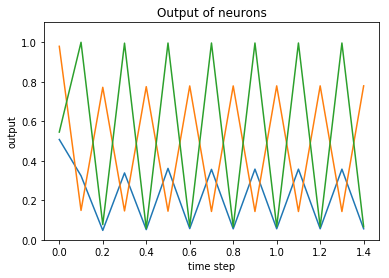

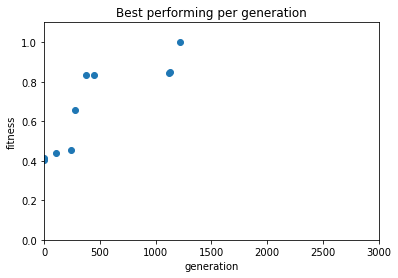







weights: [
	 [-4.802680341757676, -2.0027641428622402, 0.5150559627652758]
	 [4.390255449574589, -4.618786549302637, -13.608233275458264]
	 [-7.660061139805634, 1.7070269370308822, -3.4217190836963614]
]
taus: [0.1269923990535479, 0.1990145486127631, 0.13146685899485186]
bias: [3.910514908161389, 1.6279594397643216, 3.935663429553763]


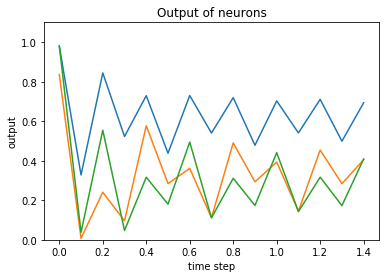

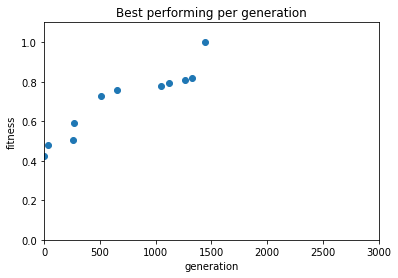







weights: [
	 [-3.9686865500643256, -0.5677677106152546, 0.9579785050375413]
	 [-12.520612122198287, -1.5735346698709147, 2.8794713166643007]
	 [-1.3429430355186138, -7.275085044384825, -13.743142656366615]
]
taus: [0.1127197930290712, 0.12322883847813253, 0.1152447355565703]
bias: [0.9102691521945445, 6.784047331269051, 8.898564360255438]


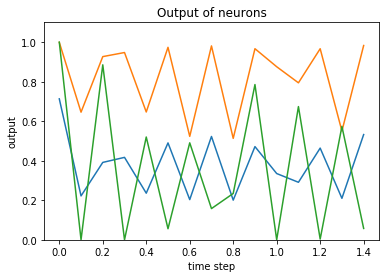

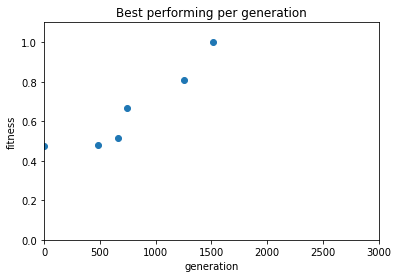







weights: [
	 [-3.938364598605455, 4.336753312611066, -0.8190175450210644]
	 [-8.758544101797025, -11.01454934555339, 13.18001420433647]
	 [11.665023835382424, 3.2078529462971233, -14.263113580022894]
]
taus: [0.287986569534984, 0.12262415428521174, 0.18136522352163525]
bias: [-1.4054153334033472, 6.409899500899595, 1.7645199790104797]


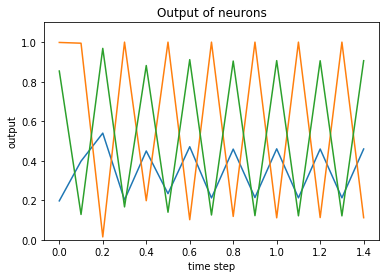

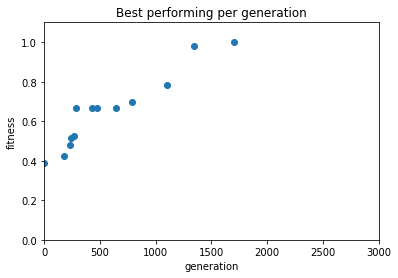

In [7]:
#Sorts and graphs the 5 best performing

print("Top 5 performing")
#Sort populations by fitness
sorted_populations = sorted(populations, key=lambda pop: pop.fittest_individual.fitness() , reverse=True)
#Print top 5 populations? Not sure what to do if multi get perfect points
for pop in sorted_populations[0:5]:
    graph_highest_fitness(pop, gen_count)
    #print(pop.highest_fitness, "==", pop.fittest_individual.fitness())

weights: [
	 [-3.446570564865766, 1.4091563510727854, -2.5486362292686318]
	 [1.0154846174077683, -13.966456022567396, 5.042566661930852]
	 [-14.368621665104351, 9.108288345037096, -10.876371446360913]
]
taus: [0.11936910464237437, 0.1600265664192085, 0.39633368738282826]
bias: [2.8523292369157325, 8.120001172722283, 2.806810108807092]


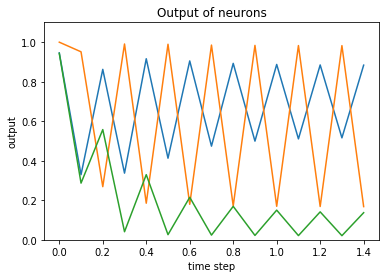

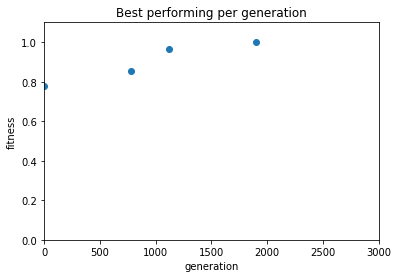

In [8]:
#Prints "worst" performing
worst_pop = sorted_populations[-1]
graph_highest_fitness(worst_pop, gen_count)

In [9]:
print("Runs for", gen_count, "reproductions/mutations aka generations")
print("Base population contains", population_size, "individuals")
print("Initial populations built with weights [-15,15], biases [-15,15], taus [0.1, 1], and states [-5, 5]")
print("Created 20 seperate populations")
print("Fitness is in the range of [0.0, 1.0]")

Runs for 3000 reproductions/mutations aka generations
Base population contains 100 individuals
Initial populations built with weights [-15,15], biases [-15,15], taus [0.1, 1], and states [-5, 5]
Created 20 seperate populations
Fitness is in the range of [0.0, 1.0]
